# Luxonis Real-Time Object Tracking in Google Colab

# Real-Time Object Tracking Simulation

This project simulates tracking of circles and rectangles in a video feed using OpenCV in Google Colab. It also produces a **tracked video** with live overlays.

## How to Run

1. Open the notebook in Google Colab.  
2. Upload the input video (`luxonis_task_video.mp4`) when prompted.  
3. Run all cells. The script will:
   - Detect and track objects frame-by-frame.  
   - Generate **`tracking_output.png`** showing object trajectories.  
   - Export **`tracking_history.csv`** listing coordinates per frame.  
   - Produce **`tracked_output.avi`** (or `.mp4`)—a video with real-time overlays of IDs and markers.  
   - Display the tracked video inline (Colab playback) or provide a download link.  
4. Download the output files using the provided links.

## Object Detector

- **Circle detection**: uses Hough Circle Transform (`cv2.HoughCircles`) on a blurred grayscale image.  
- **Rectangle detection**: finds contours (`cv2.findContours`) and approximates polygons (`cv2.approxPolyDP`), filtering for 4-vertex shapes.  
- **Color sampling**: reads the BGR value at each detected center for visualization.

## Tracker

- Assigns each detected shape a unique **Object ID**.  
- Matches objects between frames by **Euclidean distance** (`dist_thresh` parameter).  
- Tolerates temporary disappearance up to `tolerance_missing` frames:
  - Gaps in detection create visible breaks in the trajectory.  
- Ignores very short tracks (under `small_traj_thresh` pixels) to filter noise.

## Visualization

- Draws a colored line connecting consecutive detections with gaps where objects vanish.  
- **Green marker** at the start of each trajectory; **red marker** at the end.  
- Marker shape (circle or rectangle) matches the detected object shape.  
- Gaps in the line indicate frames where the object temporarily disappeared.

## Outputs

- **tracked_output.avi**: video file showing the original footage with live detection markers and ID labels.  
- **tracking_output.png**: static image of all trajectories with start/end markers and gaps.  
- **tracking_history.csv**: CSV with columns:
  - `ObjectID`, `Frame`, `X`, `Y`, `Shape`

---

*Developed for Luxonis interview task.*  


In [1]:
!pip install opencv-python-headless
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import HTML, display
import csv
import os

In [2]:
# Upload video file
print("\u2191 Upload the video file (luxonis_task_video.mp4)...")
uploaded = files.upload()
video_path = next(iter(uploaded))

↑ Upload the video file (luxonis_task_video.mp4)...


Saving luxonis_task_video.mp4 to luxonis_task_video.mp4


In [3]:
# Parameters and storage
tolerance_missing = 2   # allowed missing frames
dist_thresh = 50        # matching threshold
small_traj_thresh = 15  # ignore trajectories shorter than this (pixels)
tracked_objects = {}     # id: list of (frame_idx, x, y, color, shape)
last_positions = {}      # id: (x, y)
missing_count = {}       # id: missing frames count
object_id_counter = 0

# Utility functions
def euclidean(p1, p2):
    return np.hypot(p1[0] - p2[0], p1[1] - p2[1])

def identify_color(bgr):
    return tuple(int(c) for c in bgr)

# Video processing and tracking
cap = cv2.VideoCapture(video_path)
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 2)
    detected = []  # list of (pos, color, shape)

    # Detect circles
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1.2, 30,
                               param1=50, param2=30, minRadius=10, maxRadius=60)
    if circles is not None:
        for x, y, r in np.uint16(np.around(circles[0])):
            pos = (int(x), int(y))
            color = identify_color(frame[y, x])
            detected.append((pos, color, 'circle'))

    # Detect rectangles
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            cx, cy = x + w//2, y + h//2
            shape = 'square' if abs(w - h) < 10 else 'rectangle'
            color = identify_color(frame[cy, cx])
            detected.append(((cx, cy), color, shape))

    # Match detections to tracked objects
    matched = set()
    for pos, color, shape in detected:
        assigned = False
        for oid, last in list(last_positions.items()):
            if oid in matched:
                continue
            if euclidean(pos, last) < dist_thresh:
                tracked_objects[oid].append((frame_idx, pos[0], pos[1], color, shape))
                last_positions[oid] = pos
                missing_count[oid] = 0
                matched.add(oid)
                assigned = True
                break
        if not assigned:
            object_id_counter += 1
            tracked_objects[object_id_counter] = [(frame_idx, pos[0], pos[1], color, shape)]
            last_positions[object_id_counter] = pos
            missing_count[object_id_counter] = 0

    # Handle disappearance
    for oid in list(last_positions.keys()):
        if oid not in matched:
            missing_count[oid] = missing_count.get(oid, 0) + 1
            if missing_count[oid] > tolerance_missing:
                del last_positions[oid]
                del missing_count[oid]

    frame_idx += 1
cap.release()

In [4]:
# Visualize final trajectories and markers with disappearance gaps
canvas = np.zeros((720, 1280, 3), dtype=np.uint8)
for oid, pts in tracked_objects.items():
    # Sort by frame index
    sorted_pts = sorted(pts, key=lambda p: p[0])
    # Filter valid detections
    valid = [(fid, x, y, color, shape) for fid, x, y, color, shape in sorted_pts]
    if len(valid) < 2:
        continue
    # Skip very small trajectories
    start_f, sx, sy, _, _ = valid[0]
    end_f, ex, ey, _, _ = valid[-1]
    if euclidean((sx, sy), (ex, ey)) < small_traj_thresh:
        continue
    # Draw continuous segments only where object persists
    for i in range(1, len(valid)):
        prev_f, x1, y1, c1, _ = valid[i-1]
        cur_f, x2, y2, c2, _ = valid[i]
        # only draw if no disappearance gap
        if cur_f - prev_f == 1:
            cv2.line(canvas, (x1, y1), (x2, y2), c1, 2)
    # Start marker
    _, sx, sy, _, sshape = valid[0]
    if sshape == 'circle':
        cv2.circle(canvas, (sx, sy), 8, (0,255,0), 2)
    else:
        cv2.rectangle(canvas, (sx-6, sy-6), (sx+6, sy+6), (0,255,0), 2)
    # End marker
    _, ex, ey, _, eshape = valid[-1]
    if eshape == 'circle':
        cv2.circle(canvas, (ex, ey), 8, (0,0,255), 2)
    else:
        cv2.rectangle(canvas, (ex-6, ey-6), (ex+6, ey+6), (0,0,255), 2)


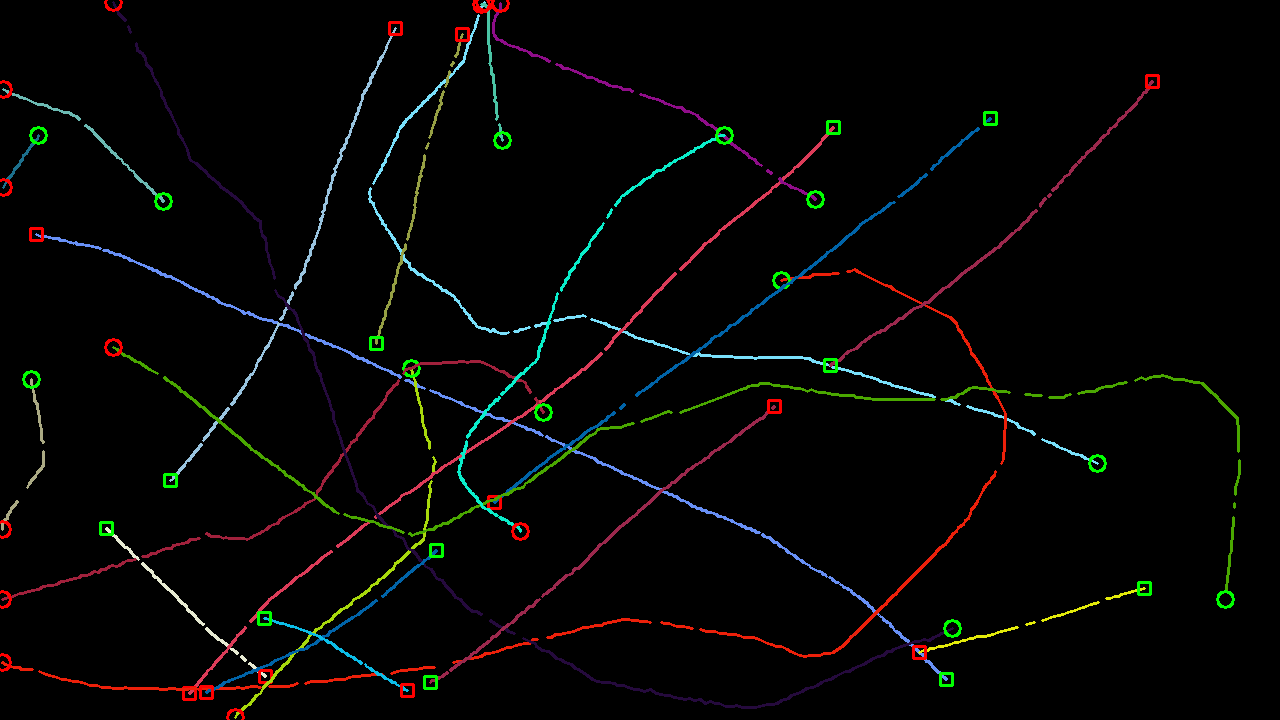

In [5]:
# Save and display
cv2.imwrite("tracking_output.png", canvas)
cv2_imshow(canvas)

# Save history CSV
with open("tracking_history.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ObjectID","Frame","X","Y","Shape"])
    for oid, pts in tracked_objects.items():
        for fid, x, y, _, shape in pts:
            writer.writerow([oid, fid, x, y, shape])

Video creation

In [6]:

tolerance_missing   = 2
dist_thresh         = 50
small_traj_thresh   = 15
tracked_objects     = {}
last_positions      = {}
missing_count       = {}
object_id_counter   = 0

# Open source video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Prepare output video writer for real-time overlay
# Use XVID codec for better compatibility
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_path = 'tracked_output.avi'  # use .avi container
writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 2)
    detected = []  # list of (pos, color, shape)

    # Detect circles
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1.2, 30,
                               param1=50, param2=30, minRadius=10, maxRadius=60)
    if circles is not None:
        for x, y, r in np.uint16(np.around(circles[0])):
            pos = (int(x), int(y))
            color = identify_color(frame[y, x])
            detected.append((pos, color, 'circle'))

    # Detect rectangles
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            cx, cy = x + w//2, y + h//2
            shape = 'square' if abs(w - h) < 10 else 'rectangle'
            color = identify_color(frame[cy, cx])
            detected.append(((cx, cy), color, shape))

    # Match detections to tracked objects
    matched = set()
    for pos, color, shape in detected:
        assigned = False
        for oid, last in list(last_positions.items()):
            if oid in matched:
                continue
            if euclidean(pos, last) < dist_thresh:
                tracked_objects[oid].append((frame_idx, pos[0], pos[1], color, shape))
                last_positions[oid] = pos
                missing_count[oid] = 0
                matched.add(oid)
                assigned = True
                break
        if not assigned:
            object_id_counter += 1
            tracked_objects[object_id_counter] = [(frame_idx, pos[0], pos[1], color, shape)]
            last_positions[object_id_counter] = pos
            missing_count[object_id_counter] = 0

    # Handle disappearance
    for oid in list(last_positions.keys()):
        if oid not in matched:
            missing_count[oid] = missing_count.get(oid, 0) + 1
            if missing_count[oid] > tolerance_missing:
                del last_positions[oid]
                del missing_count[oid]

        # Overlay tracking on current frame
    overlay = frame.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    for oid, pos in last_positions.items():
        x, y = pos
        color = tracked_objects[oid][-1][3]
        # draw circle marker
        cv2.circle(overlay, (x, y), 10, color, 2)
        # prepare text label above marker
        text = f"ID{oid}"
        (tw, th), _ = cv2.getTextSize(text, font, 0.6, 2)
        # draw filled rectangle for contrast
        rect_x1, rect_y1 = x + 8, y - 12 - th
        rect_x2, rect_y2 = x + 8 + tw, y - 12 + 4
        cv2.rectangle(overlay, (rect_x1, rect_y1), (rect_x2, rect_y2), (0, 0, 0), -1)
        # draw text label
        cv2.putText(overlay, text, (x+10, y-8), font, 0.6, color, 2)

    # Write to output video
    writer.write(overlay)

In [7]:
# Download results
files.download("tracking_output.png")
files.download("tracking_history.csv")
files.download(out_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>